# Bank Customer Churn -  XGBOOST 


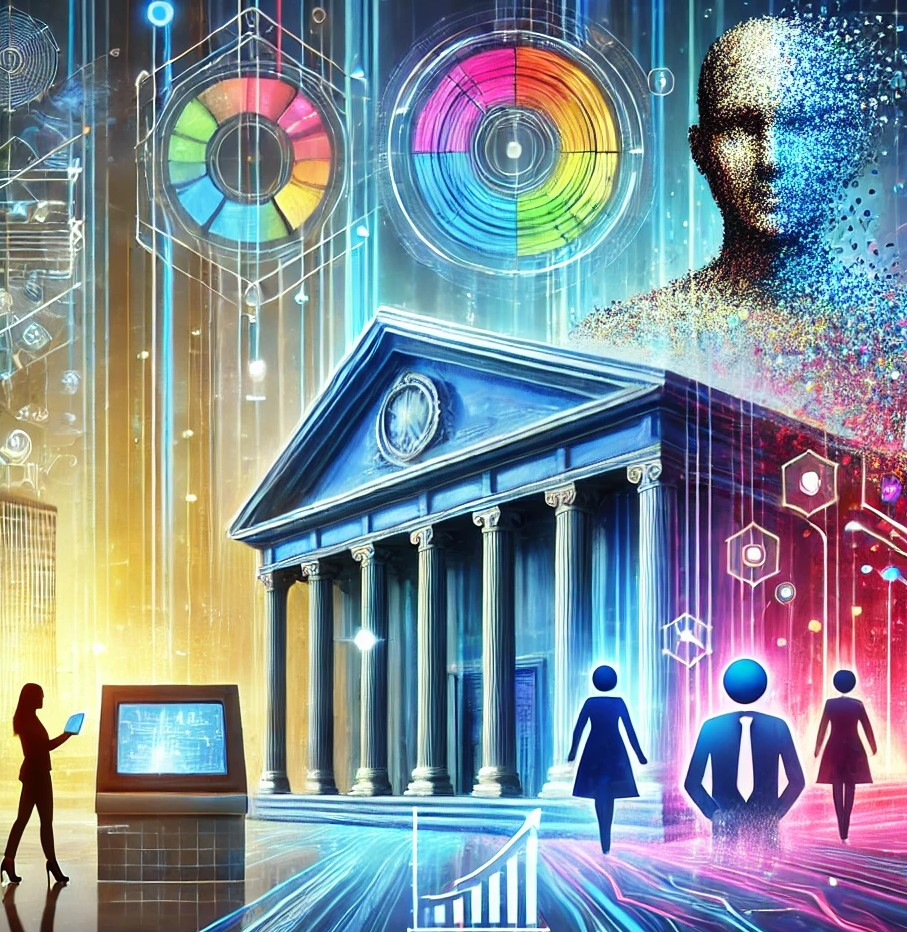

# Importando Bibliotecas 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import logging
import optuna
import xgboost as xgb
import torch

from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score,
    roc_curve, confusion_matrix, auc
)

from optuna.samplers import TPESampler
import pickle

########################### para KAGGLE ################################################################################################################
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
########################################################################################################################################################


# Dicinário de Dados 


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


# Análise Exploratória (EDA) & Data Wrangling 


In [ ]:

# base_original = pd.read_csv('/kaggle/input/Customer-Churn-Records.csv', sep=',') #KAGGLE
base_original = pd.read_csv('C:/Users/jgeov/iCloudDrive/Treinamento/Treinamento Data Science/Projetos/Customer-Churn-Records.csv',sep=',') #LOCAL

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)

#primeiras linhas 
base_original.head()

Analisando primeiras impressões da base de dados


In [ ]:
#Dimensões 
print("Numero de linhas:", base_original.shape[0]) 
print("Numero de colunas:", base_original.shape[1])


In [ ]:
#tipos
base_original.dtypes

In [ ]:
#checando se há valores nulos 
base_original.isnull().sum()  
#valores nulos nao encontrados 

In [ ]:
#removidas por serem meramente identificadoras: RowNumber, CustomerId e Surname 

df = base_original[['CreditScore',
                    'Gender',
                    'Geography',
                    'Age',
                    'Tenure',
                    'Balance',
                   'NumOfProducts',
                    'HasCrCard',
                    'IsActiveMember',
                   'EstimatedSalary',
                    'Complain',
                    'Satisfaction Score',
                   'Card Type',
                    'Point Earned',
                    'Exited'
                   ]]

# Resumo estatístico 
quanti = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]
resumo_estati_quant = quanti.describe().style.format(lambda x: f'{x:,.1f}'.replace(',', 'X').replace('.', ',').replace('X', '.')) # Formatação com 1 casa decimal e separadores invertidos

resumo_estati_quant

* Resumo estatistico de variaveis qualitativas (frequancias)

* Os resumos estatisticos sao importantes para primeiras nocoes de desbalance, a amplitude e distribuicao de valores
minimos maximos e um breve entendimento se serao necessarios tratamentos nessas variaveis, decorrentes dessas observacoes; 

* Podemos notar que a principio as ditribuicoes nao sao absurdas e o desbalance esta pricipalemnte nas variavies Complain e Exited (variavel alvo do estudo, a chamaremos de churn) indicando que sera necessario tratar isso;

* Franca tem mais observacoes que os demais paises; 

* A maioria dos clientes tem cartao de credito; 

* A maioria dos clientes tem entre 1 e 2 produtos. 


In [ ]:
#Resumo estatistico 

#separando quali's para analise 
quali = df[['HasCrCard', 'IsActiveMember', 'Geography','Gender'
            ,'Complain','Exited','Card Type','NumOfProducts','Satisfaction Score']]

quali = quali.astype('object')

#quali.dtypes



def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,
                f'{int(height)}',
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,
                          boxstyle='round,pad=0.4', linewidth=1))

plt.figure(figsize=(20, 25))

# Geography
plt.subplot(5, 2, 1)
ax1 = plt.gca()
ax1.set_title('Geography', fontsize=22, fontweight='bold')
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax1)

# Gender
plt.subplot(5, 2, 2)
ax2 = plt.gca()
ax2.set_title('Gender', fontsize=22, fontweight='bold')
sns.countplot(x='Gender', hue='Gender', palette='viridis', data=base_original, ax=ax2, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax2)

# Complain
plt.subplot(5, 2, 3)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# HasCrCard
plt.subplot(5, 2, 4)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# IsActiveMember
plt.subplot(5, 2, 5)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Card Type
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# NumOfProducts
plt.subplot(5, 2, 7)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)


# Satisfaction Score
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)






# Exited
plt.subplot(5, 2, 9)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando espaçamento
plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.show()




* Visualizando o comportmento da variavel alvo (exited) em relacao as demais variaveis; 

* Vemos claramente que existe o disbalance de classes na variavel churn, pela cor verde presente fortemente em todas variaveis, posteriormente isso sera tratado/mitigado; 

* Ja e possivel notar um forte indicio de alta correlacao entre churn e complain, posteriormente isso sera testado. 



In [ ]:
#%% Variável alvo em relação as demais variáveis 





plt.figure(figsize=(20, 25)) #tamanho do painel grafico

#funcao de adicao de legenda no canto superior direito e garante rotulos 
def add_legend(ax):
    
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        
        # Se não houver handles, forca a adicao
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']
        
    # Adiciona a legenda fora da área das barras
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',  
              bbox_to_anchor=(1.0, 1)) 




# Geography
plt.subplot(5, 2, 1)
counts = base_original.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Gender
plt.subplot(5, 2, 2)
counts = base_original.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by Gender', fontsize=22, fontweight='bold')
plt.xlabel('Gender', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# NumOfProducts
plt.subplot(5, 2, 3)
counts = base_original.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard
plt.subplot(5, 2, 4)
counts = base_original.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember
plt.subplot(5, 2, 5)
counts = base_original.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca()) 
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain
plt.subplot(5, 2, 6)
counts = base_original.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score
plt.subplot(5, 2, 7)
counts = base_original.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type
plt.subplot(5, 2, 8)
counts = base_original.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())  
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.ylabel('', fontsize=16)
plt.xticks(fontsize=14, rotation=0,fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta a distância entre os gráficos
plt.subplots_adjust(hspace=0.7, wspace=0.3)

# Variaveis Dummies

* A maioria dos modelos necessita de transformar as variaveis categoricas em numericas, e o modelo MLP (Multilayer Perceptron) e um deles; 

* A transformacao de categoricas em numericas precisa ser feita com processos adequados para nao cometer ponderacao arbitrária no desenvolvimento. 

* foi aplicado one-hot encoding para isso. Esse processo e chamado de "Dummizacao". 
 

In [ ]:
# Dumizando

# Suprime todos os warnings de futuro (deixa mais clean) 
warnings.filterwarnings('ignore', category=FutureWarning)



# Lista de variaveis a serem transformadas
cols_to_transform = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Card Type']

# Convertendo para string
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# one-hot encoding 
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=False)



# variável alvo 'Exited' para o tipo numérico, pois o modelo requer isso de todas as varaiveis (por isso dumizar)
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

print(df_dummies.dtypes)

# Separação Treino e Teste & Adicao de Features quadráticas

* A separacao em treino e teste alem de uma boa pratica e extreamente necessario na construcao de modelos de machine learning; 

* Tambem foram adicionadas variaveis quadraticas, ou seja, com operacao matematica aplicadas em variaveis originais gerando novas variaveis. Isso foi feito para capturar algum tipo de comportamento nao linear; 

* Foi considerado aplicar transformacao polinomial nas variaveis, por isso foi primeiro aplicado o termo quadratico, que nao apresentou melhoria significativa a ponto de aplicarmos polinomias; 

* Alem disso MLPs capturam naturalmente comportamentos nao lineares. O termo quadratico foi util para validacao durante o estudo mas a melhoria foi baixa, por isso mantemos apenas os termos quadraticos sem incluir interacoes entre variaveis (seria aplicacao Polinomias completo); 



* Tambem e possivel notar o desbalanceamento das classes  nas bases tanto em treino quanto em teste no grafico final; 

* Tambem garantimos a mesma proporcao (80/20) tanto em treino quanto em teste na separacao das bases , ou seja, equidade de divisao de dados e equilibrio. 


In [ ]:
#X ---> Variáveis explicativas 
#Y ---> Evento de estudo (variável TARGET, evento de estudo, ^y etc..)

df_dummies = df_dummies.drop(columns=['Complain']) #correlacao altissima com a variavel alvo


X = df_dummies .drop('Exited', axis=1)

# VARIAVEIS QUADRATICAS 
X['Balance_Squared'] = X['Balance'] ** 2
X['Age_Squared'] = X['Age'] ** 2
X['CreditScore_Squared'] = X['CreditScore'] ** 2
X['NumOfProducts_Squared'] = X['NumOfProducts'] ** 2
X['Tenure_Squared'] = X['Tenure'] ** 2
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2



y =  df_dummies['Exited']


#separando em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Visualizando a proporção de eventos de churn (TARGET) nas bases de TREINO e TESTE 

# Contando os valores 
churn_counts_train = y_train.value_counts()
churn_counts_test = y_test.value_counts()


# plot que contem os graficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  
cmap = plt.get_cmap('viridis', 2) #paleta de cores



# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)
axs[0].set_xlabel('Churn', fontsize=20)
axs[0].set_ylabel('Contagem', fontsize=20)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['0', '1'], fontsize=20)
axs[0].set_yticklabels([]) # Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_train = churn_counts_train.sum()
for bar in bars_train:
    count = int(bar.get_height())
    percentage = round(count / total_train * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')




# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)
axs[1].set_xlabel('Churn', fontsize=20)
axs[1].set_ylabel('Contagem', fontsize=20)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['0', '1'], fontsize=20)
axs[1].set_yticklabels([])# Ocultando os valores do eixo y

# Adicionando rótulos de dados
total_test = churn_counts_test.sum()
for bar in bars_test:
    count = int(bar.get_height())
    percentage = round(count / total_test * 100)  # Arredonda a porcentagem
    label = f'{count} ({percentage}%)'  #valor absoluto e o percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
                label, ha='center', color='gray', fontsize=25, weight='bold')



# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  # forca espaco para o titulo
plt.show()




# Verificando correlacoes depois de construcao total de features e Dummizacao 

* Verificar as correlacoes e extreammente importante, elas podem indicar a famosa multicolinearidade, que atrapalha a maioria dos modelos; 

* no caso da MLP (pelo menos a presente aplicacao) ela nao afetou, a observei com atencao, mas nao impactou. Decidi manter as variveis mesmo com multicolinearidade em algumas (nao se assuste). 



In [ ]:
#Observando Multicolinearidade na base de treino

teste_multco_treino = pd.concat([X_train,y_train], axis = 1)

correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino

# Matrix com  mapa de calor 
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(correlation_matrix_treino, annot=True, fmt=".2f",
                      cmap=plt.cm.viridis_r, # paleta de cores viridis (ou viridis_r para o inverso de cores) é uma paleta especial 
                                             # para facilitar a visualizacao por pessoas com dificuldades visuais, como os daltonicos. 
                      annot_kws={'size': 15}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
plt.title('Correlação das Variáveis Quantitativas na Base de Treino',fontsize=25)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

# Analise e tratamento de Outliers 

* Outliers sao numericos e podem afetar de diversas formas modelos de MLP porque eles utilizam backpropagation e descida do gradiente, entre outras coisas que podem atrapalhar a capacidade preditiva do modelo; 

* para resolver sem perder dados, pois temos poucas observcoes para estudo, nao foram removidos como facilmente poderia fazer-se, ao inves foi aplicado winsorization; 

* winsorization e uma tecnica de limitacao dos outliers, ela substiui os valores de outlierns pelos limites superiores e inferiores; 

* Para isso, e calculado um intervalo de valores aceitos com base no primeiro quartil (Q1) e no terceiro quartil (Q3), valores abaixo do limite inferior ou acima do limite superior sao ajustados para os respectivos limites, corrigindo assim os outliers 

In [ ]:
#%% analise de outliers das variaveis na base de treino 


###############antes de tratamento############################# 
variaveis = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'EstimatedSalary',
    'Satisfaction Score',
    'Point Earned',
    #QUADRATICAS
    'Balance_Squared',
    'Age_Squared',
    'CreditScore_Squared',
    'NumOfProducts_Squared',
    'Tenure_Squared',
    'EstimatedSalary_Squared'
]


# definindo tamnhos de subplots 
plt.figure(figsize=(16, 12))

# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='lightblue'))  # Cor interna do boxplot 
    plt.title(f'Boxplot {var}', fontsize=12)
    
#  título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - antes de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajuste de layout
plt.show()
###############################################################






# Função que aplica winsorization
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Substitui outliers pelo limite inferior ou superior
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])





###############depois de tratamento############################# 

# Aplicando a função nas variáveis 
variaveis_para_tratar = ['CreditScore',
                        'Age',
                        'Tenure',
                        'Balance',
                        'NumOfProducts',
                        'EstimatedSalary',
                        'Satisfaction Score',
                        'Point Earned',
                        #QUADRATICAS
                        'Balance_Squared',
                        'Age_Squared',
                        'CreditScore_Squared',
                        'NumOfProducts_Squared',
                        'Tenure_Squared',
                        'EstimatedSalary_Squared'
                         ]
for variavel in variaveis_para_tratar:
    tratar_outliers(teste_multco_treino, variavel)


# subplot
plt.figure(figsize=(16, 12))



# loop de criacao de boxplots para cada variavel 
for i, var in enumerate(variaveis):
    plt.subplot(5, 4, i + 1)  #determina a grade de plots 
    sns.boxplot(y=teste_multco_treino[var],
               boxprops=dict(facecolor='green'))  # Cor interna do boxplot
    plt.title(f'Boxplot {var}', fontsize=12)
########################################################################


# título geral
plt.suptitle('Análise de Outliers nas Variáveis(treino) - depois de "winsorization" ', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # ajusta layout
plt.show()

In [ ]:
#BASE DE TREINO 
teste_multco_treino

In [ ]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


# Preparacao dos dados  


* Preparacao dos dados 


In [ ]:
print('------------------------')
print(" DATA Prep")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ################################################################### 



# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis 
#detalhe importante, nao tem predict(), somente o fit() 
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))


# Mostrar o gráfico
plt.show()




# Finalizando preparacao e selecionando variaveis

Variaveis selecionadas conforme o modelo classificador de importancia usado anteriormente (randomforest) 

In [ ]:

print("Shape X_train antes de selecionar as fetuares importantes:", X_train.shape)
print("Shape y_train antes de selecionar as fetuares importantes:", y_train.shape)


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)


start_time_utc = datetime.utcnow() - timedelta(hours=3)
print("Tempo de Início:", start_time_utc)
print('------------------------')


X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train, y_train = X_train_selected , y_train
X_test, y_test = X_test_selected , y_test

print("Shape X_train (selecionadas):", X_train.shape)
print("Shape y_train (selecionadas):", y_train.shape)

print("Shape X_test (selecionadas):", X_test.shape)
print("Shape y_test (selecionadas):", y_test.shape)


#verificando alinhamneto
assert X_train.shape[0] == y_train.shape[0], "Erro: Número de amostras não coincide"
assert X_test.shape[0] == y_test.shape[0], "Erro: Número de amostras não coincide"


# **Ensemble Model** 